#### 회귀 모델 - 주택 가격 예측 예시


#### Data load / Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# data load 
housing = fetch_california_housing() 
X = pd.DataFrame(housing.data, columns=housing.feature_names) 
y = housing.target 

# data shape
print(f"데이터 형태: {X.shape}")
print(f"타겟 형태: {y.shape}")
print("\n특성 이름:")
print(housing.feature_names)
print("\n데이터셋 설명:")
print(housing.DESCR[:500] + "...")  # 설명 일부만 출력

# 데이터 상위 5개 행 확인
print("\n데이터 미리보기:")
print(X.head())

# 기본 통계량 확인
print("\n기본 통계량:")
print(X.describe())

# 결측치 확인
print("\n결측치 개수:")
print(X.isnull().sum())

데이터 형태: (20640, 8)
타겟 형태: (20640,)

특성 이름:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

데이터셋 설명:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group popu...

데이터 미리보기:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352

#### 2. NaN 값 처리 및 EDA

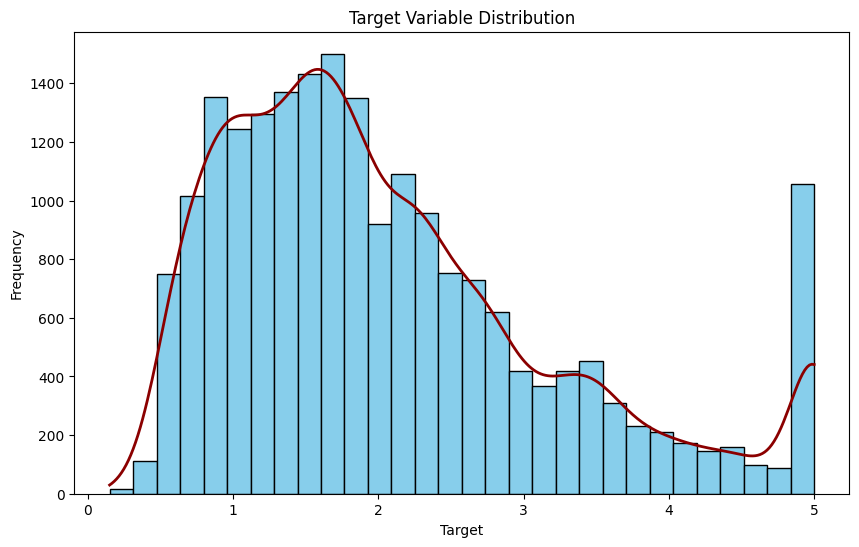

In [2]:
# 타겟 변수 분포
from scipy.stats import gaussian_kde
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(y, bins=30, color='skyblue', edgecolor='black')
kde = gaussian_kde(y)
x_vals = np.linspace(min(y), max(y), 300)
plt.plot(x_vals, kde(x_vals)*len(y)*(bins[1]-bins[0]), color='darkred', linewidth=2)
plt.title('Target Variable Distribution')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

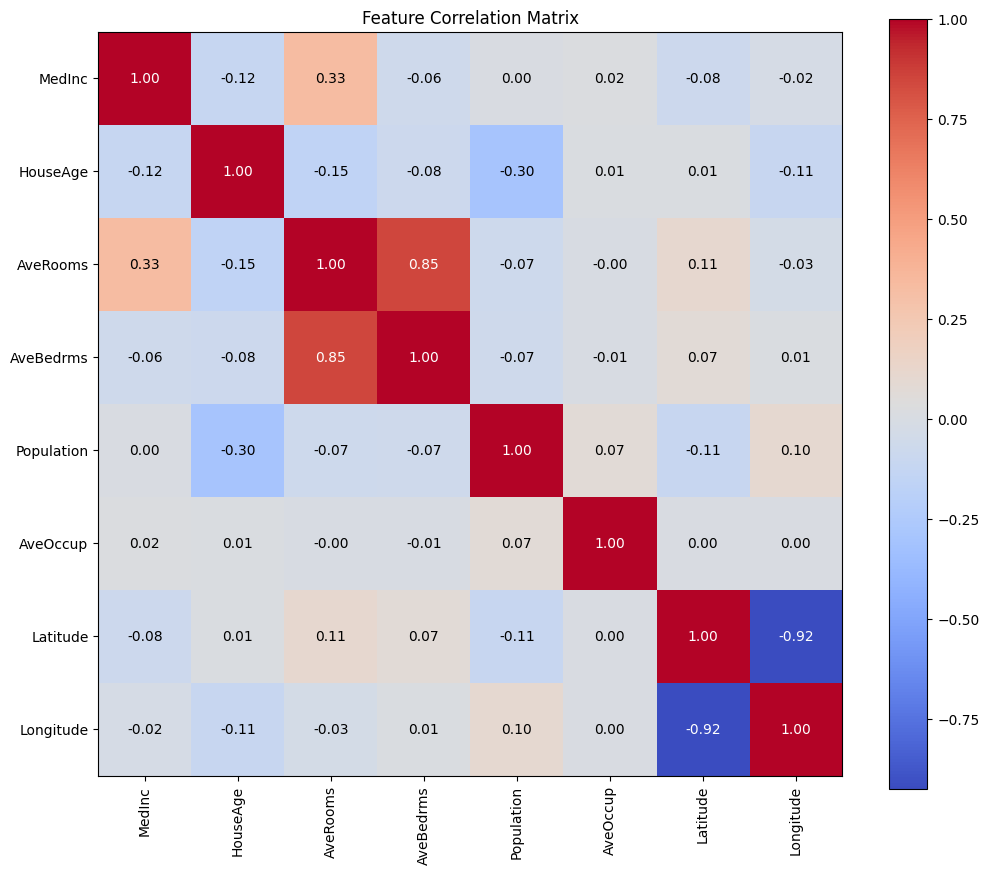

In [3]:
# 특성 관 correlation matric 
corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Feature Correlation Matrix')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

# 상관계수 값 표기
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                ha='center', va='center', 
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
plt.show()


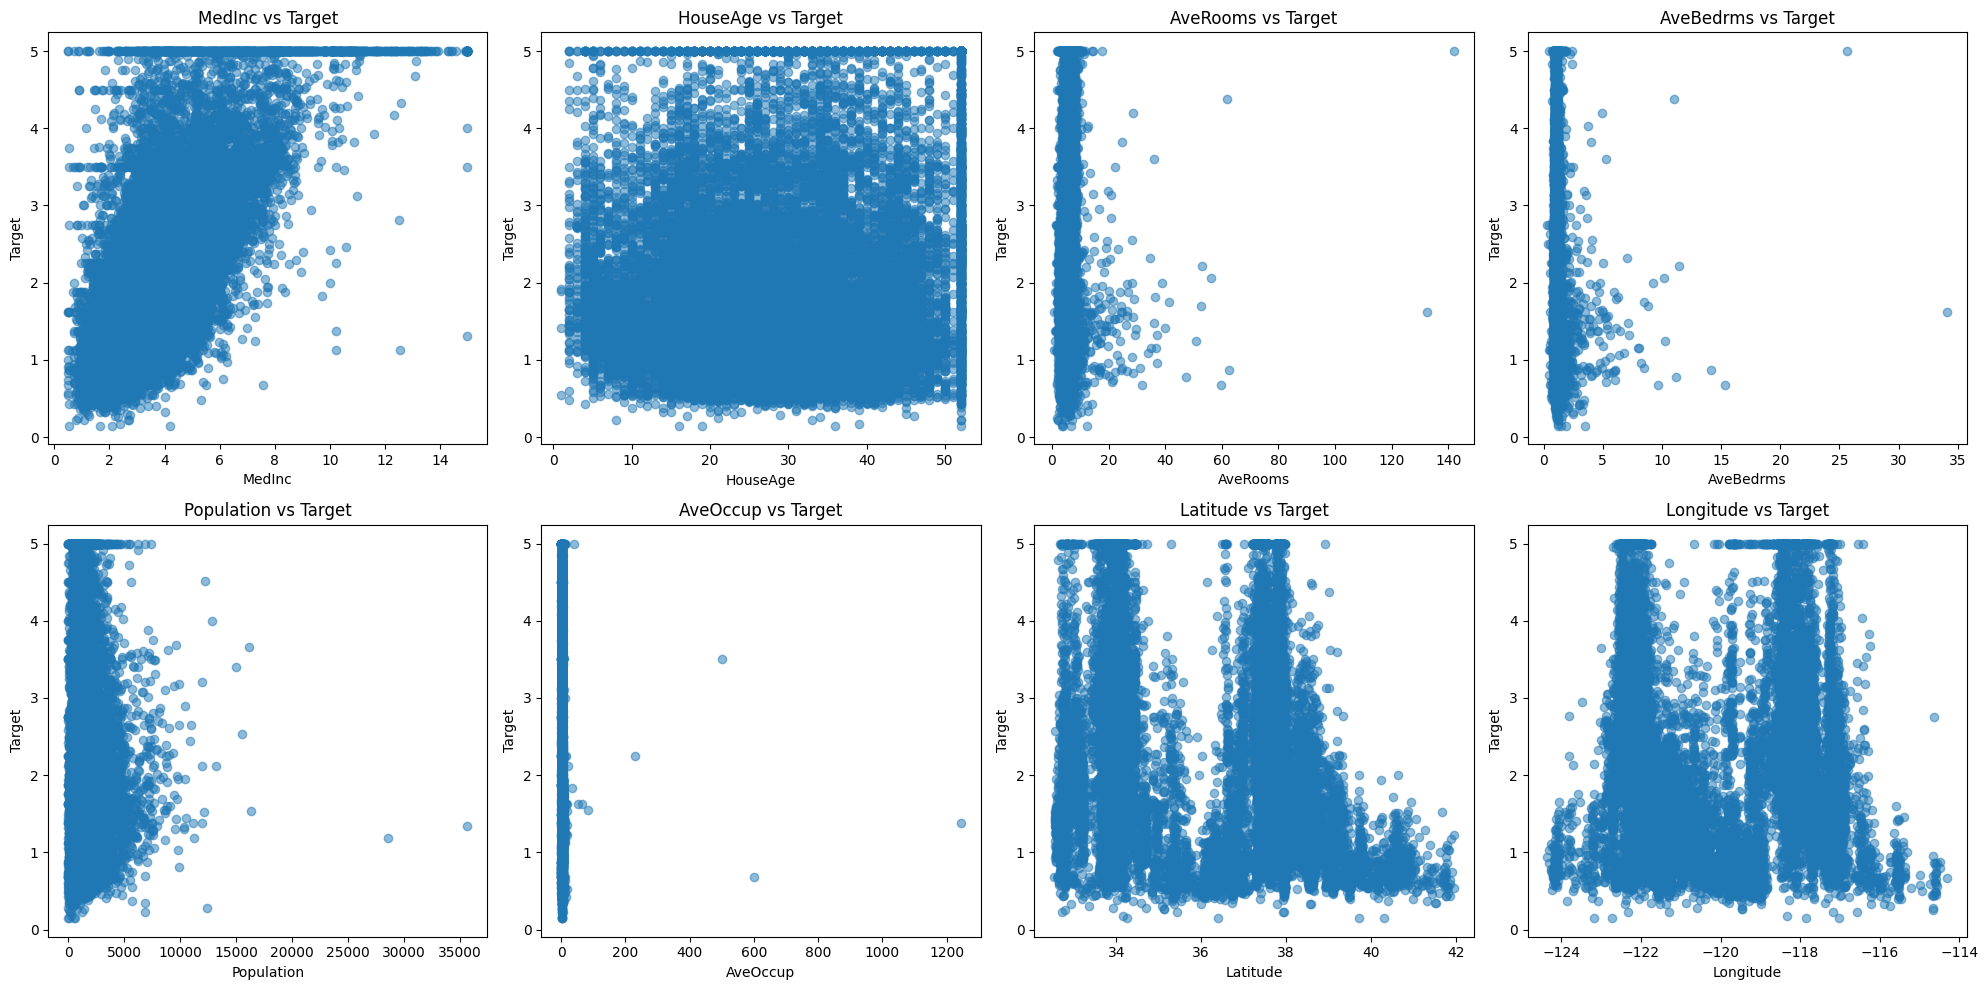

In [4]:
# 타겟 변수와 특성 간 산점도
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    axes[i].scatter(X[feature], y, alpha=0.5)
    axes[i].set_title(f'{feature} vs Target')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Target')

plt.tight_layout()
plt.show()

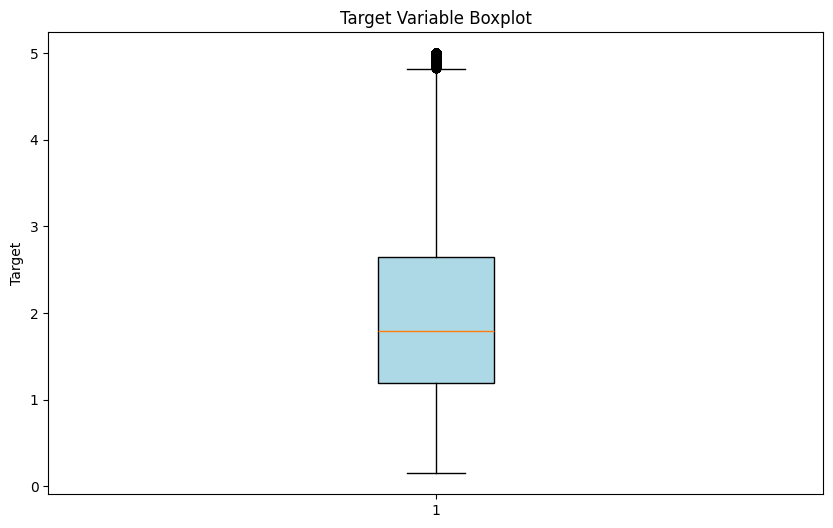

In [ ]:
# 타겟 변수의 box plot
plt.figure(figsize=(10, 6))
plt.boxplot(y, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Target Variable Boxplot')
plt.ylabel('Target')
plt.show()


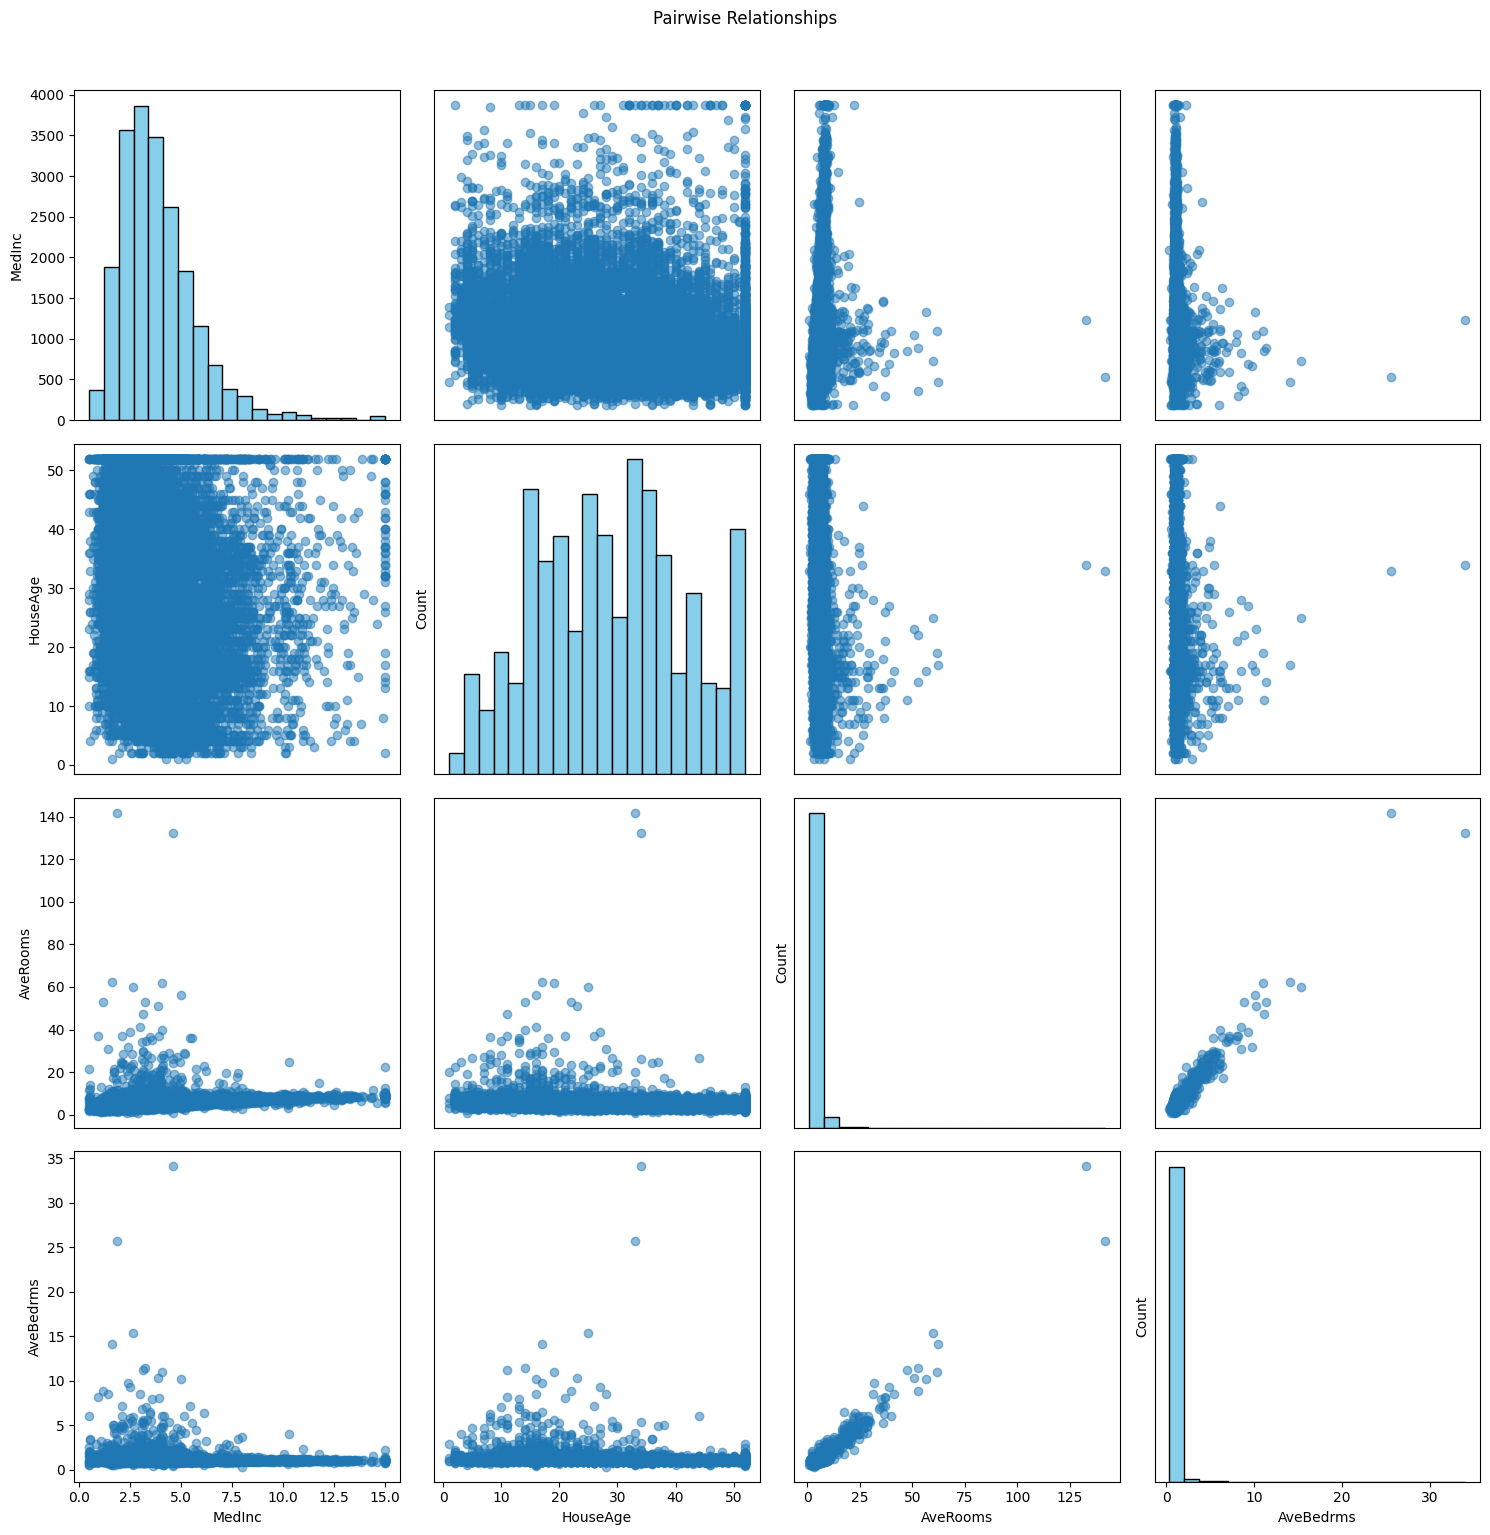

In [6]:
# pairplot
selected_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms']
plot_data = X[selected_features].copy()
plot_data['Target'] = y

num_features = len(selected_features)
fig, axes = plt.subplots(num_features, num_features, figsize=(15, 15))

for i in range(num_features):
    for j in range(num_features):
        ax = axes[i, j]
        if i == j:
            ax.hist(plot_data[selected_features[i]], bins=20, color='skyblue', edgecolor='black')
            ax.set_ylabel('Count')
        else:
            ax.scatter(plot_data[selected_features[j]], plot_data[selected_features[i]], alpha=0.5)
        if i == num_features - 1:
            ax.set_xlabel(selected_features[j])
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(selected_features[i])
        else:
            ax.set_yticks([])

plt.suptitle('Pairwise Relationships', y=1.02)
plt.tight_layout()
plt.show()


#### 3. Data Preprocessing 

학습 데이터 형태: (16512, 8)
테스트 데이터 형태: (4128, 8)

각 특성별 이상치 개수:
MedInc: 529개
HouseAge: 0개
AveRooms: 410개
AveBedrms: 1153개
Population: 955개
AveOccup: 582개
Latitude: 0개
Longitude: 0개


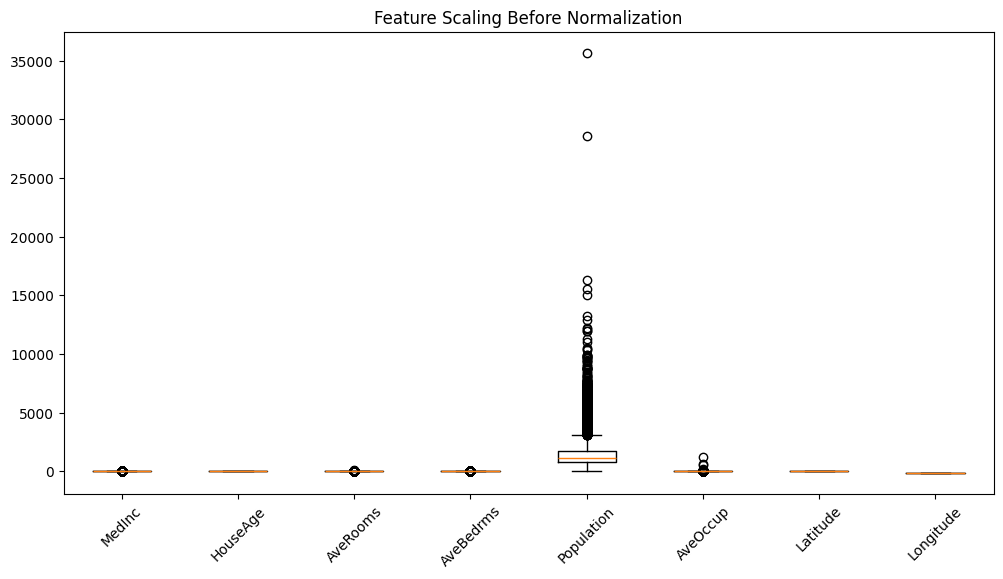


다중공선성 확인 (VIF):
      Feature         VIF
7   Longitude  641.224254
6    Latitude  560.583263
3   AveBedrms   48.332634
2    AveRooms   46.792373
0      MedInc   11.831609
1    HouseAge    7.155405
4  Population    2.915730
5    AveOccup    1.080609


In [8]:
# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")

# 이상치 처리: IQR 방법으로 이상치 확인 (데모 목적)
def detect_outliers(df):
    outliers = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

outliers = detect_outliers(X_train)
print("\n각 특성별 이상치 개수:")
for col, count in outliers.items():
    print(f"{col}: {count}개")

# 본 예제에서는 이상치를 제거하지 않고 진행

# 특성 스케일링 확인 (특성 간 스케일 차이)
plt.figure(figsize=(12, 6))
plt.boxplot(X_train)
plt.xticks(range(1, len(X_train.columns) + 1), X_train.columns, rotation=45)
plt.title('Feature Scaling Before Normalization')
plt.show()

# 다중공선성 확인 - VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print("\n다중공선성 확인 (VIF):")
print(vif_data.sort_values("VIF", ascending=False))



#### 4. Model selection and fitting 

In [9]:
# 다양한 회귀 모델 평가
models = {
    'Linear Regression': LinearRegression(), 
    'Ridge Regression': Ridge(), 
    'Lasso Regression': Lasso(), 
    'ElasticNet': ElasticNet(), 
    'RandomForest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42) 
}
# 전처리 파이프라인 생성
preprocessor = StandardScaler()

# 각 모델별 교차 검증 수행
cv_results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # 교차 검증
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    
    cv_results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std()
    }
    
    print(f"{name} - RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")

# 가장 성능이 좋은 모델 선택
best_model_name = min(cv_results, key=lambda k: cv_results[k]['mean_rmse'])
print(f"\n최적 모델: {best_model_name}")

# 최적 모델 파이프라인 생성 및 학습
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models[best_model_name])
])

best_pipeline.fit(X_train, y_train)

Linear Regression - RMSE: 0.7205 (±0.0103)
Ridge Regression - RMSE: 0.7205 (±0.0103)
Lasso Regression - RMSE: 1.1562 (±0.0128)
ElasticNet - RMSE: 1.0289 (±0.0123)
RandomForest - RMSE: 0.5115 (±0.0045)
Gradient Boosting - RMSE: 0.5340 (±0.0071)
XGBoost - RMSE: 0.4765 (±0.0056)

최적 모델: XGBoost


Pipeline(steps=[('preprocessor', StandardScaler()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

#### 5. Predict


테스트 데이터에 대한 모델 성능:
MSE: 0.2226
RMSE: 0.4718
MAE: 0.3096
R²: 0.8301


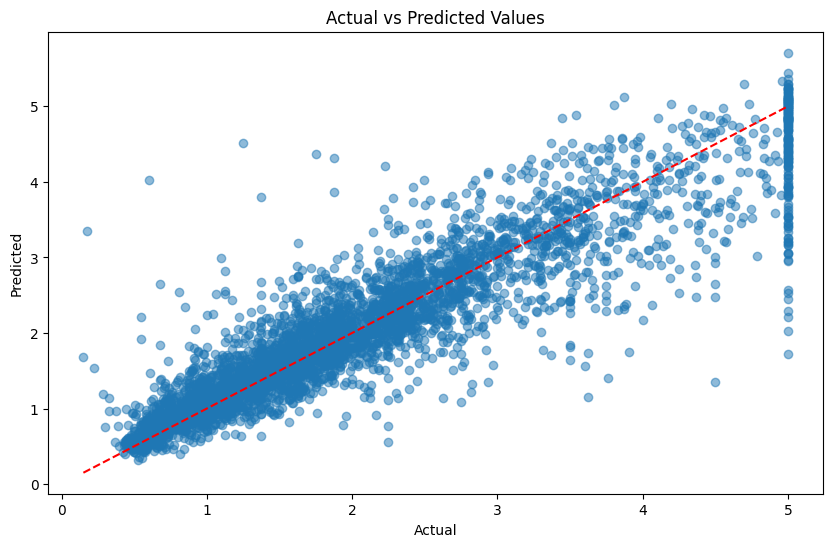

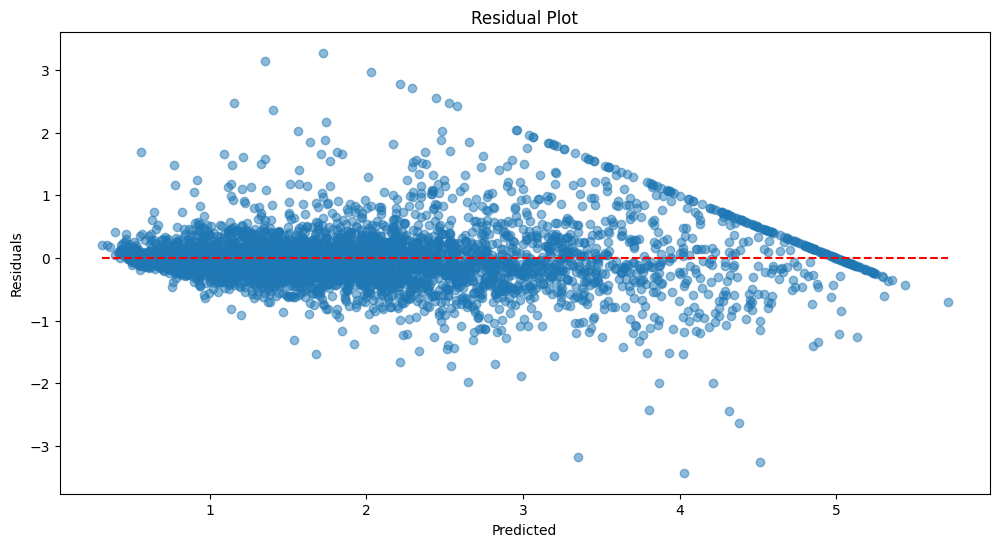

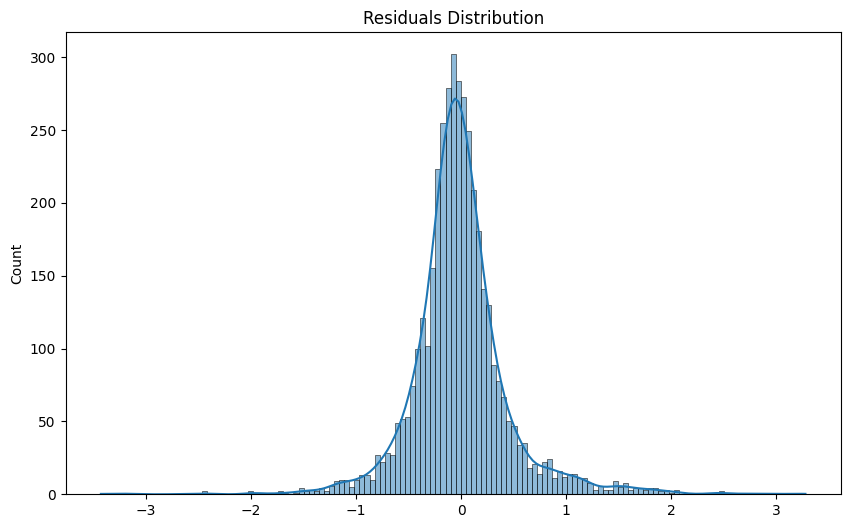

In [10]:
# 테스트 데이터에 대한 예측

y_pred = best_pipeline.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n테스트 데이터에 대한 모델 성능:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 실제값과 예측값 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# 잔차 분석
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()


#### 6. Model tuning


하이퍼파라미터 튜닝 중...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
최적 하이퍼파라미터: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 300, 'regressor__subsample': 0.9}
최고 RMSE: 0.4535
튜닝 후 RMSE: 0.4464


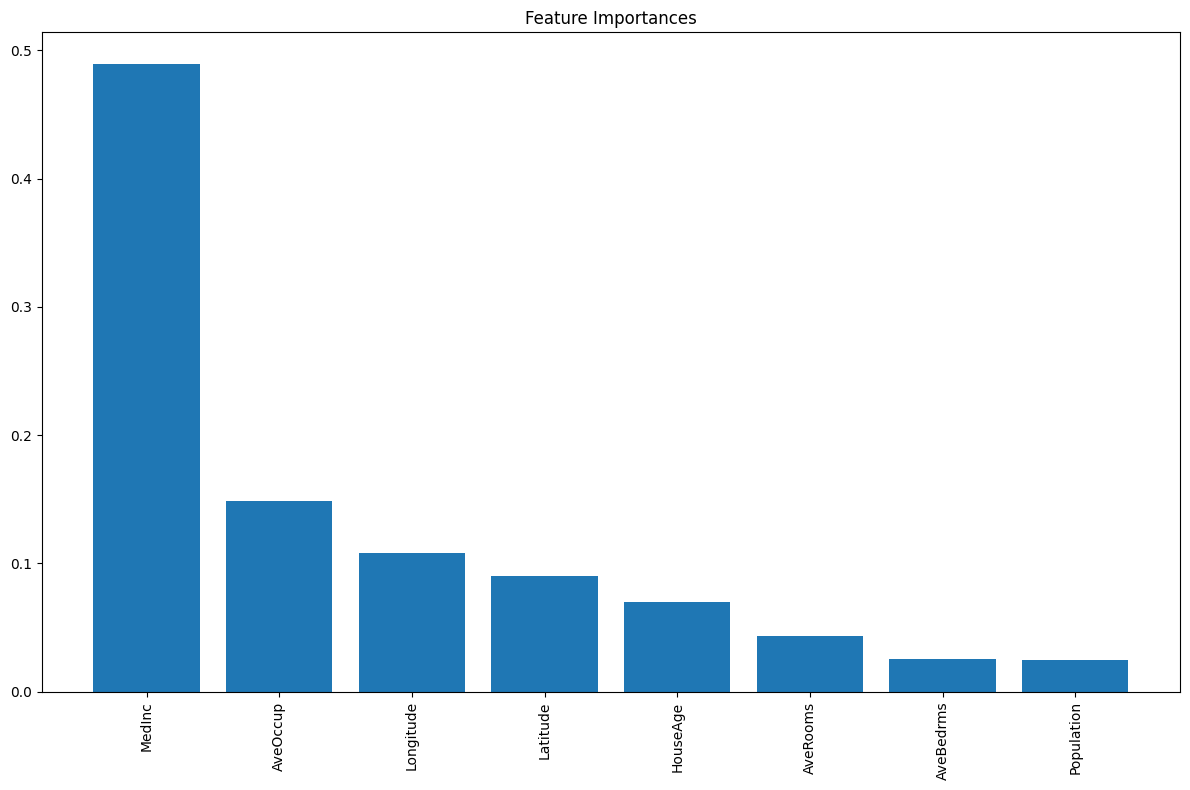


모델이 'regression_model.pkl'로 저장되었습니다.


In [11]:
# 하이퍼파라미터 튜닝 - 랜덤 포레스트 예시
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [10, 20, 30, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__colsample_bytree': [0.8, 0.9, 1.0]
    }
else:
    param_grid = {}  # 다른 모델의 경우 적절한 그리드 설정

if param_grid:
    print("\n하이퍼파라미터 튜닝 중...")
    grid_search = GridSearchCV(
        best_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # 그리드 서치 실행 (시간이 오래 걸릴 수 있음)
    # 실제 환경에서는 아래 코드의 주석을 해제하고 실행
    grid_search.fit(X_train, y_train)
    print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
    print(f"최고 RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
    
    # 튜닝된 모델로 다시 예측
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    print(f"튜닝 후 RMSE: {rmse_tuned:.4f}")

# 특성 중요도 시각화 (트리 기반 모델의 경우)
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    regressor = best_pipeline.named_steps['regressor']
    
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importances')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

# 모델 저장
joblib.dump(best_pipeline, 'regression_model.pkl')
print("\n모델이 'regression_model.pkl'로 저장되었습니다.")
